This here notebook is going to be a test of Optical Image Subtraction, a random routine I found on the internet!

https://optimal-image-subtraction.readthedocs.io/en/stable/index.html

After the proof of concept, this one will just do the subtraction on all the images relative to the reference. In this model, we might NOT be able to do differential photometry, and may need to rely on instrumental flux.

In [1]:
import os  #Call commands from outside Python
import shutil # Running external programs
from ois import optimal_system
from astropy.io import fits #FITS files handling
from astropy.stats import sigma_clipped_stats, SigmaClip # statistics
import matplotlib.pyplot as plt #Plot
from reproject import reproject_interp # for reprojection
from astropy.coordinates import SkyCoord # For the coordinate of the source into pixels
from astropy.wcs import WCS # for the cropping routine

# for cropping
from astropy.nddata import Cutout2D
from astropy import units as u
import math

In [2]:
# Some global parameters
# source position (needed for the windowed subtraction scheme)
RA=128.249
Dec=-27.449311
window=200 #Size of subtraction region.

# Flags
initial_images_flag=1 #See raw input images
display_align_flag = 1 # See initial aligned images
show_diff_flag=1 # show the difference step

In [3]:
# Set directory structure
cwd = os.getcwd()

print("You start from the directory:", cwd)

source_dir = os.path.join(cwd, 'source') # All the stacked, WCS-solved files should be in here.
proc_dir = os.path.join(cwd, 'processed') # all processes fits files.
if os.path.isdir(proc_dir): # checks and removes if it exists. 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)
for f in os.listdir(source_dir): # copy source files into processed directory 
    shutil.copy2(os.path.join(source_dir, f), proc_dir)

# change to that directory for all our work.
os.chdir(proc_dir)
print("You are working in the image_subtraction/processed/ directory: ")
print("Full path:", proc_dir)

You start from the directory: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/OIS
You are working in the image_subtraction/processed/ directory: 
Full path: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/OIS/processed


## Verify Images

Just check out the raw images first (flag to turn off?)

In [4]:
init_name_array=[]
for f in os.listdir(source_dir): # create list of raw images
    init_name_array.append(f)
    
init_name_array.sort() # sorted by name so that discovery is first.

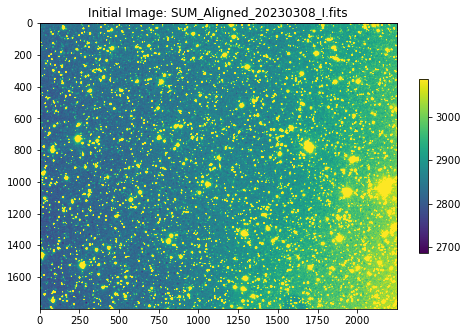

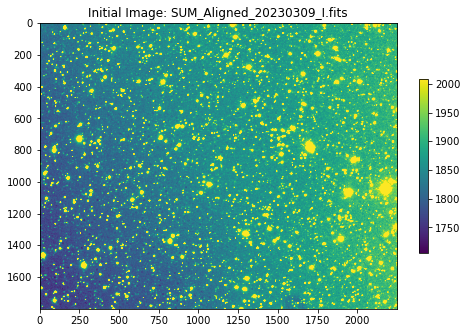

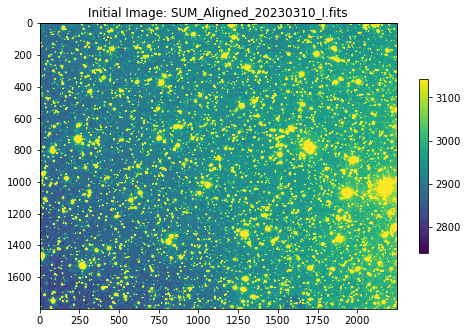

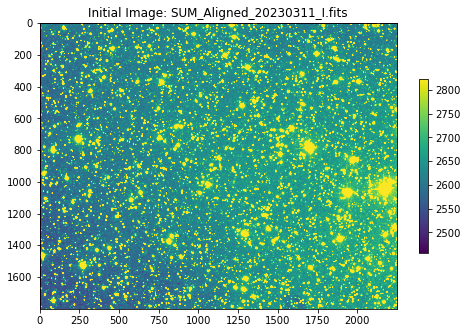

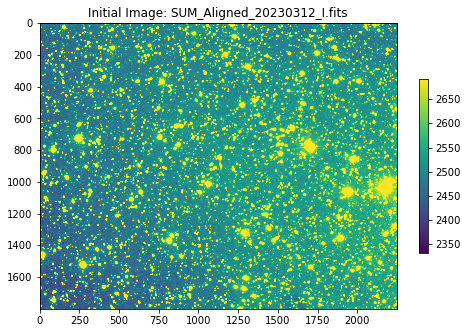

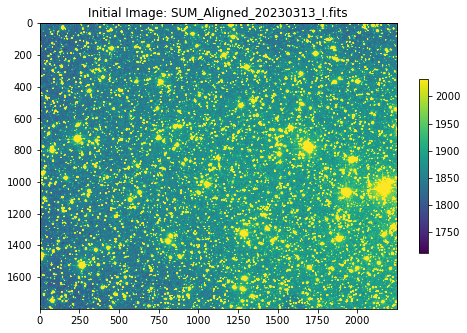

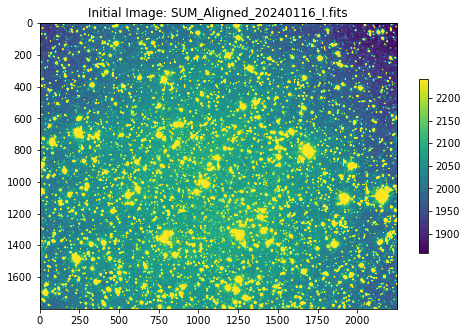

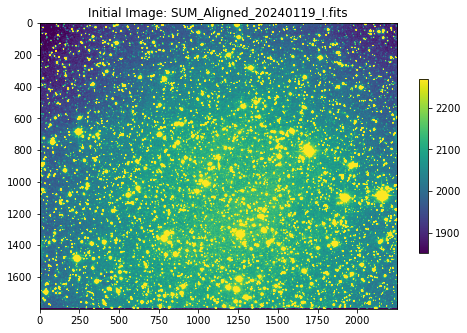

In [5]:
if (initial_images_flag == 1):
    init_name_array
    for f in init_name_array:
        image = fits.open(f)
        mean, median, std = sigma_clipped_stats(image[0].data)
        plt.figure(figsize=(8,8))

        plt.imshow(image[0].data, vmin=median-2*std, vmax=median+2*std)
        plt.colorbar(shrink = 0.4)
        plt.title('Initial Image: '+f)
        plt.show()

## Align the Images

This was done with SWARP before, but seems like we can do it with reproject: https://github.com/astropy/reproject

We are going to project each of the science images onto the reference (which is the last one in the list).

Resampling Image: SUM_Aligned_20230308_I.fits


Set MJD-AVG to 60012.134168 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60329.224664 from DATE-AVG'. [astropy.wcs.wcs]


Resampling Image: SUM_Aligned_20230309_I.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Resampling Image: SUM_Aligned_20230310_I.fits


Set MJD-AVG to 60014.073589 from DATE-AVG'. [astropy.wcs.wcs]


Resampling Image: SUM_Aligned_20230311_I.fits


Set MJD-AVG to 60015.081432 from DATE-AVG'. [astropy.wcs.wcs]


Resampling Image: SUM_Aligned_20230312_I.fits


Set MJD-AVG to 60016.074924 from DATE-AVG'. [astropy.wcs.wcs]


Resampling Image: SUM_Aligned_20230313_I.fits


Set MJD-AVG to 60017.073582 from DATE-AVG'. [astropy.wcs.wcs]


Resampling Image: SUM_Aligned_20240116_I.fits


Set MJD-AVG to 60326.182749 from DATE-AVG'. [astropy.wcs.wcs]


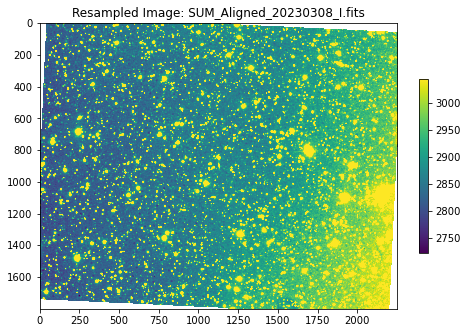

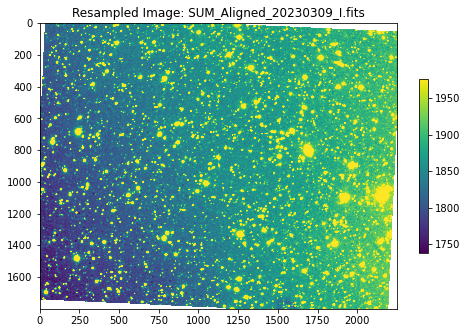

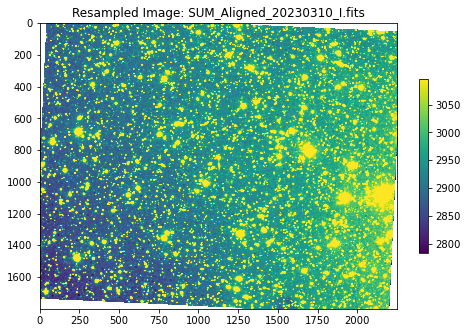

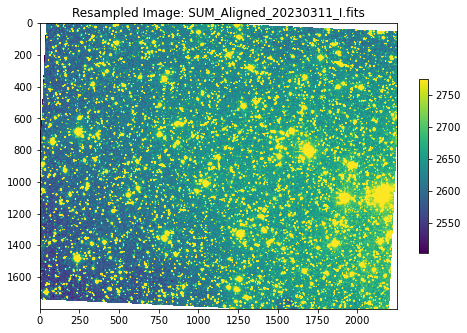

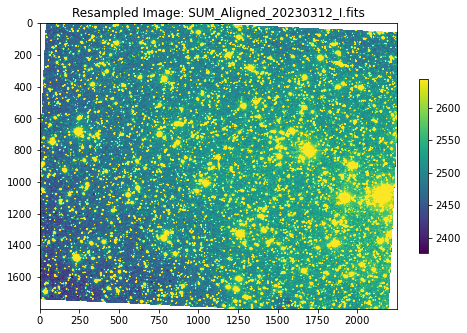

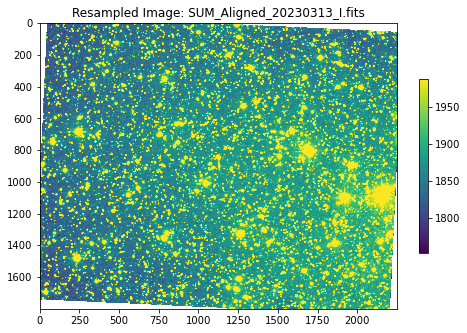

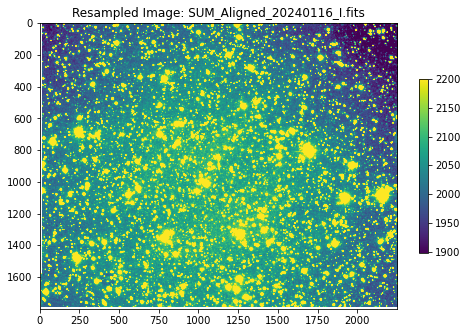

In [6]:
#In this block we should maybe write these out to fits files so we can keep track of the names!

align_image_list=[]
for i in range(len(init_name_array)-1):
    print("Resampling Image:",init_name_array[i])
    projected_image,footprint = reproject_interp(init_name_array[i],init_name_array[len(init_name_array)-1])
    align_image_list.append(projected_image)

if (display_align_flag == 1 ):
    for i in range(len(align_image_list)):
        #image = fits.open(f)
        mean, median, std = sigma_clipped_stats(align_image_list[i])
        plt.figure(figsize=(8,8))

        plt.imshow(align_image_list[i], vmin=median-2*std, vmax=median+2*std)
        plt.colorbar(shrink = 0.4)
        plt.title('Resampled Image: '+init_name_array[i])
        plt.show()

## OIS Subtraction Routine

First crop the images down...

In [7]:
size=(window,window)
coord = SkyCoord(RA,Dec,unit='deg')
ref_image = fits.open(init_name_array[len(init_name_array)-1])
w = WCS(ref_image[0].header)
x, y = w.world_to_pixel(coord)
print("The source is located at: ",x,y)
#position = (math.floor(refimage[0].data.shape[0]/2),math.floor(refimage[0].data.shape[1]/2))
#position

The source is located at:  1125.4726540084266 894.6561377960052


Set MJD-AVG to 60329.224664 from DATE-AVG'. [astropy.wcs.wcs]


In [8]:
# Also going to have a flux within the aperture thing going on, for immediate results
from photutils.aperture import CircularAperture, ApertureStats
aper = CircularAperture((window/2,window/2), 8)
#aperstats = ApertureStats(data, aper)

In [9]:
aper

<CircularAperture([100., 100.], r=8.0)>

In [10]:
from photutils.aperture import aperture_photometry

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0    50218.901


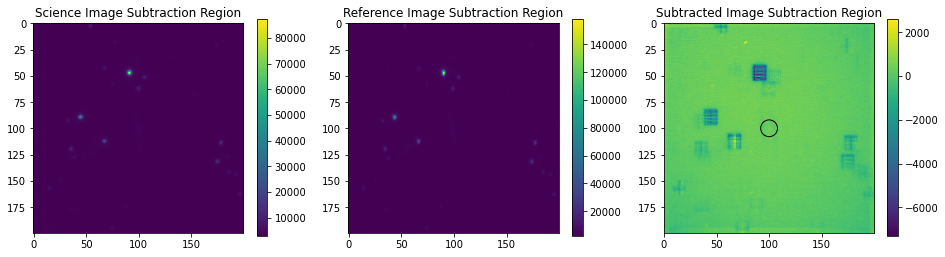

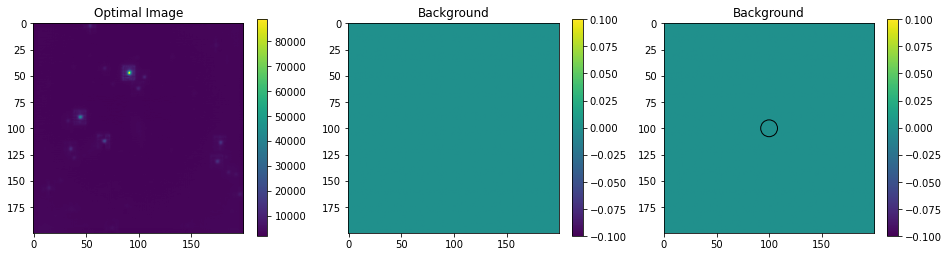

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0    39844.405


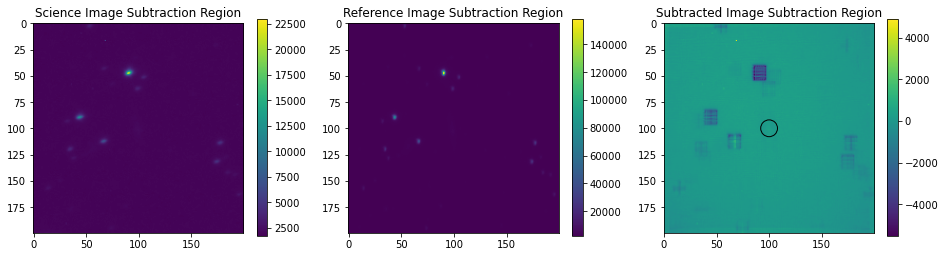

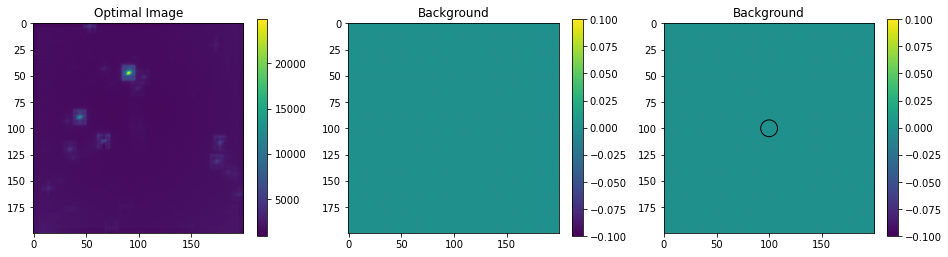

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0    38869.752


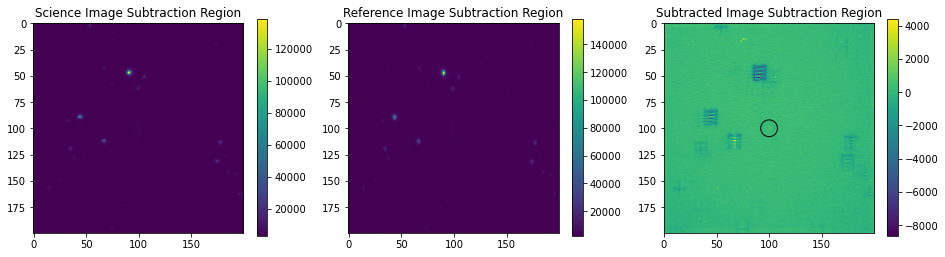

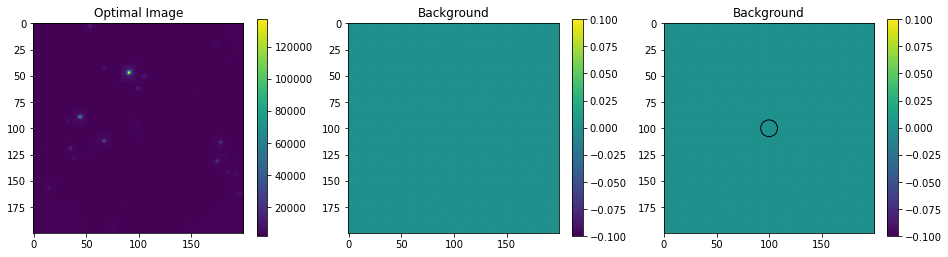

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0    29594.198


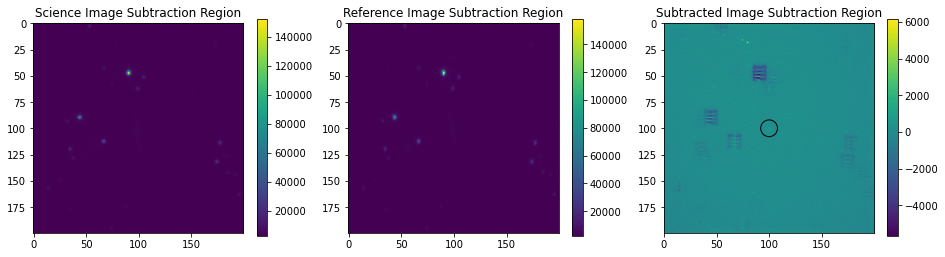

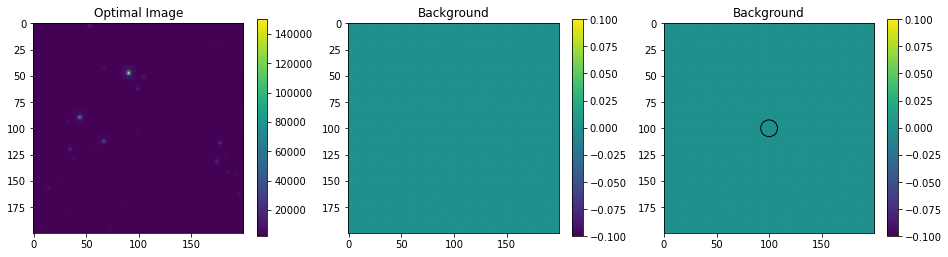

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0    24204.636


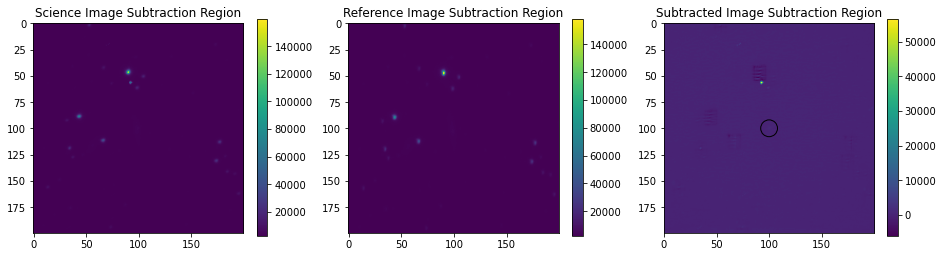

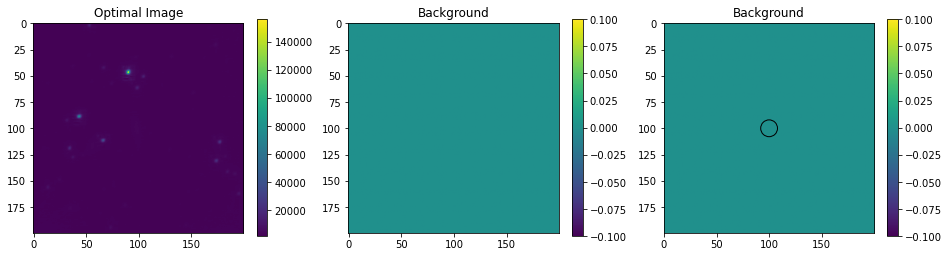

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0    7986.7098


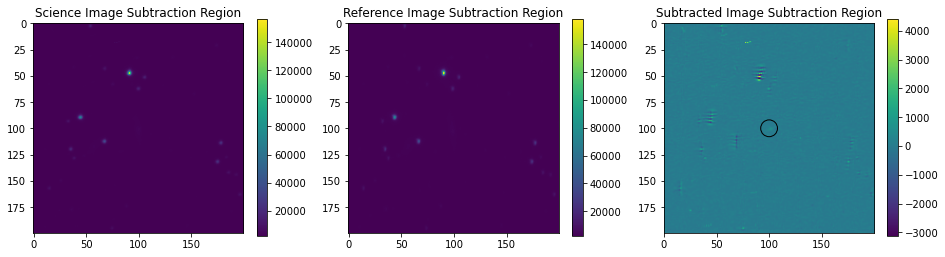

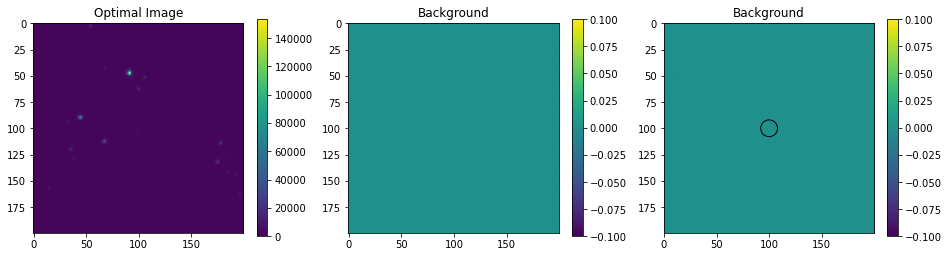

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   100.0   100.0   -1675.2575


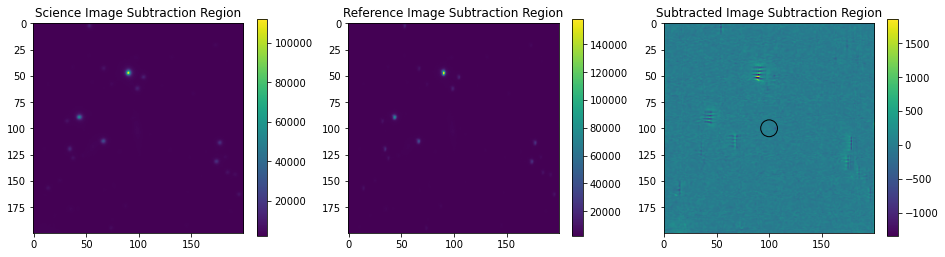

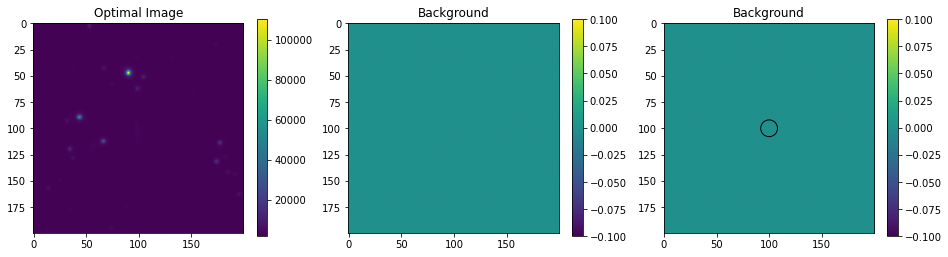

In [11]:
ref_cutout = Cutout2D(ref_image[0].data, (x,y), size)
diff_list=[]
raw_flux=[]
for i in range(len(align_image_list)):
    sci_cutout=Cutout2D(align_image_list[i], (x,y), size)
    
    diff_image, optimal_image, kernel, background = optimal_system(sci_cutout.data, ref_cutout.data,method="AdaptiveBramich")
    diff_list.append(diff_image)
    raw_flux.append(ApertureStats(diff_image, aper).sum)
    phot_table = aperture_photometry(diff_image, aper)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output

    print(phot_table)
    
    if (show_diff_flag==1):
        # plotting step - not working yet!!!!
        # JEsus christ, we have to get the titles in before the imshow command or the colorbar doens't know what to do!
        fig, axs = plt.subplots(1, 3,figsize=(16,16))
        im0=axs[0].set_title('Science Image Subtraction Region')
        im0=axs[0].imshow(sci_cutout.data)
        fig.colorbar(im0,ax=axs[0],shrink=0.25)
        #plt.show()
    
        im1=axs[1].set_title('Reference Image Subtraction Region')
        im1=axs[1].imshow(ref_cutout.data)
        fig.colorbar(im1,ax=axs[1],shrink=0.25)
        #plt.show()
    
        im2=axs[2].set_title('Subtracted Image Subtraction Region')
        #x,y=w.world_to_pixel(coord)
    
        im2=axs[2].imshow(diff_image.data)
        #mask = aper.to_mask(method='exact')
        
        #im2=axs[2].plot(aper)
        # NOT THE ACTUAL REGION!
        aper.plot()
        #im2=axs[2].scatter(window/2, window/2, marker='o', color='r', facecolors='none',s=1000,linewidths=2)
        #axs[2].colorbar(shrink = 0.4)
        fig.colorbar(im2,ax=axs[2],shrink=0.25)
        plt.show()
        
        
        fig, axs = plt.subplots(1, 3,figsize=(16,16))
        im0=axs[0].set_title('Optimal Image')
        im0=axs[0].imshow(optimal_image.data)
        fig.colorbar(im0,ax=axs[0],shrink=0.25)
        #plt.show()
    
        im1=axs[1].set_title('Background')
        im1=axs[1].imshow(background.data)
        fig.colorbar(im1,ax=axs[1],shrink=0.25)
        #plt.show()
    
        im2=axs[2].set_title('Background')
        #x,y=w.world_to_pixel(coord)
    
        im2=axs[2].imshow(background.data)
        #mask = aper.to_mask(method='exact')
        
        #im2=axs[2].plot(aper)
        # NOT THE ACTUAL REGION!
        aper.plot()
        #im2=axs[2].scatter(window/2, window/2, marker='o', color='r', facecolors='none',s=1000,linewidths=2)
        #axs[2].colorbar(shrink = 0.4)
        fig.colorbar(im2,ax=axs[2],shrink=0.25)
        plt.show()

In [12]:
ApertureStats(diff_image, aper).sum_aper_area


<Quantity 201.06192983 pix2>

In [13]:
print(raw_flux)

[50218.90131189623, 39844.40520501902, 38869.751504350585, 29594.19812163805, 24204.636418196314, 7986.709776636941, -1675.257462987106]
